# How much effort would it take to jump between West Hall and East Hall?

Mellie Zito and Annie Tor

ModSim Section 1, Group 13

In [133]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Intial Set-up

In [134]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree

<Unit('degree')>

In [135]:
params = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = 45 * degree, #initial launch angle
                velocity = 40 * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [136]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [137]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [138]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [139]:
def event_func(state, t, system):
    """Stop when the y coordinate is 15.74.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y 

### Work on this later: 

### Optimal launch angle

To find the launch angle that maximizes distance from home plate, we need a function that takes launch angle and returns range.

In [140]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

Let's test `range_func`.

In [141]:
%time range_func(45, params)

Wall time: 73.1 ms


<Quantity(145.98651835321346, 'meter')>

And sweep through a range of angles.

In [142]:
angles = linspace(0, 90, 30)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    print(angle, x_dist)
    sweep[angle] = x_dist

0.0 61.0477513058441 meter
3.103448275862069 69.41130402920658 meter
6.206896551724138 78.33646989725241 meter
9.310344827586206 87.56901009953002 meter
12.413793103448276 96.82834858418124 meter
15.517241379310345 105.84217851402477 meter
18.620689655172413 114.36610076413714 meter
21.724137931034484 122.19145981251242 meter
24.82758620689655 129.14548615930067 meter
27.93103448275862 135.0878994471798 meter
31.03448275862069 139.90765111999536 meter
34.13793103448276 143.52479067812266 meter
37.241379310344826 145.87869971517333 meter
40.3448275862069 146.9256370125002 meter
43.44827586206897 146.63701081626655 meter
46.55172413793103 144.99737513418796 meter
49.6551724137931 142.00402683422004 meter
52.758620689655174 137.66557182846185 meter
55.86206896551724 132.00162881487853 meter
58.96551724137931 125.0428836011352 meter
62.06896551724138 116.83160632233823 meter
65.17241379310344 107.42302142976399 meter
68.27586206896552 96.88805598354134 meter
71.37931034482759 85.3163941688

Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

Saving figure to file figs/chap10-fig03.pdf


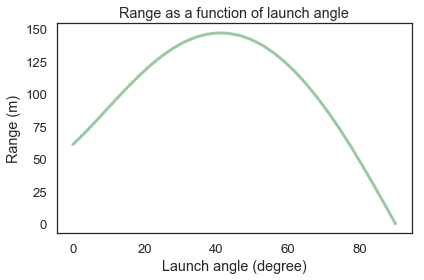

In [143]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [144]:
%time res = max_bounded(range_func, [0, 90], params)

Wall time: 909 ms


`res` is an `ModSimSeries` object with detailed results:

In [145]:
res

,values
fun,146.98035766503887 meter
status,0
success,True
message,Solution found.
x,41.2316
nfev,9


`x` is the optimal angle and `fun` the optional range.

In [146]:
optimal_angle = res.x * degree

<Quantity(41.23158609174126, 'degree')>

In [147]:
max_x_dist = res.fun

<Quantity(146.98035766503887, 'meter')>

### Under the hood

Read the source code for `max_bounded` and `min_bounded`, below.

Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

In [148]:
%psource max_bounded

In [149]:
%psource min_bounded

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a params as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [150]:
system = make_system(params)

def event_func(state, t, system):
    """Stop when the x coordinate is 94.5m.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate - 94.5m
    """
    x, y, vx, vy = state
    return x - 94.5 * m

event_func(system.init, 0, system)

def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    y_dist = get_last_value(results.y) * m
    return y_dist

height_func(45 * degree, params)

results = max_bounded(height_func, [0, 90], params)
#should be 44.5

,values
fun,50.90691163642795 meter
status,0
success,True
message,Solution found.
x,54.962
nfev,11


With initial velocity 40 m/s and an optimal launch angle, the ball clears the Green Monster with a little room to spare.

Which means we can get over the wall with a lower initial velocity.

### Finding the minimum velocity

Even though we are finding the "minimum" velocity, we are not really solving a minimization problem.  Rather, we want to find the velocity that makes the height at the wall exactly 11 m, given given that it's launched at the optimal angle.  And that's a job for `fsolve`.

Write an error function that takes a velocity and a `Params` object as parameters.  It should use `max_bounded` to find the highest possible height of the ball at the wall, for the given velocity.  Then it should return the difference between that optimal height and 11 meters.

In [151]:
params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [152]:
def error_func2(v, params):
    params.velocity = v * m/s
    system = make_system(params)
    results = max_bounded(height_func, [0, 90], params)
    height = results.fun
    return height - 11 * m

Test your error function before you call `fsolve`.

In [153]:
error_func2(40, params)

<Quantity(0.04782805563812076, 'meter')>

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [154]:
fsolve(error_func2, 40, params)

array([39.98806408])

And just to check, run `error_func` with the value you found.

In [155]:
error_func2(39.98806408, params)

<Quantity(6.653905870734889e-09, 'meter')>